In [65]:
#Import deps 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold


# ... 

### Introduction
What makes the perfect bottle of wine? 

Wine is a major industry, with sales projected to steadily grow beyond $40 billion USD by 2029. [Source](https://www.statista.com/statistics/922403/global-wine-market-size/)

For the longest time, the secrets of the timeless art of winemaking were restricted to the intuitions and implicit knowledge of the vintners themselves. Today it is possible to apply the techniques of machine learning to analyze the chemical components of wine to determine how they influence the quality rating of the wine.

This study conducts machine learning analysis on the chemical constitutents of 6497 different wines (1599 reds and 4898 white ) to identify the predictive relationships between these features and wine quality. 

The purpose of this study is to show how machine learning can be applied to commercial pursuits and potentially improve sales and production quality of products. 


In [66]:
# Import Data 
all_wine_raw_df = pd.read_csv('./Wine_data_both.csv') 
red_wine_df = pd.read_csv('./Wine_data_red.csv')
white_wine_df = pd.read_csv('./Wine_data_white.csv')


In [67]:
# Inspect raw data 
print('All wine data types', all_wine_raw_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  Wine                  6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB
All wine data types None


### Data Preparation, Encoding & Feature Engineering

In [83]:

# Wines are to be classified as "low", "medium", or "high"
def assign_category(quality):
    if quality <=5:
        return 'low'
    elif quality == 6:
        return 'medium'
    elif quality >6:
        return 'high'

# Manually encode the wine type, 0 is White, Red is 1
# all_wine_raw_df['wine type'] = all_wine_raw_df['wine type'].map({'White': 0, 'Red': 1})

# Apply the assign_category function 
all_wine_raw_df['wine_category'] = all_wine_raw_df['quality'].apply(lambda quality: assign_category(quality))
# Manually encode the wine category
all_wine_raw_df['wine_category'] = all_wine_raw_df['wine_category'].map({'low': 0, 'medium': 1, 'high': 2})
# Define the feature and target variables
X = all_wine_raw_df.drop(columns=['quality', 'Wine'], axis=1)
y = all_wine_raw_df['quality']


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

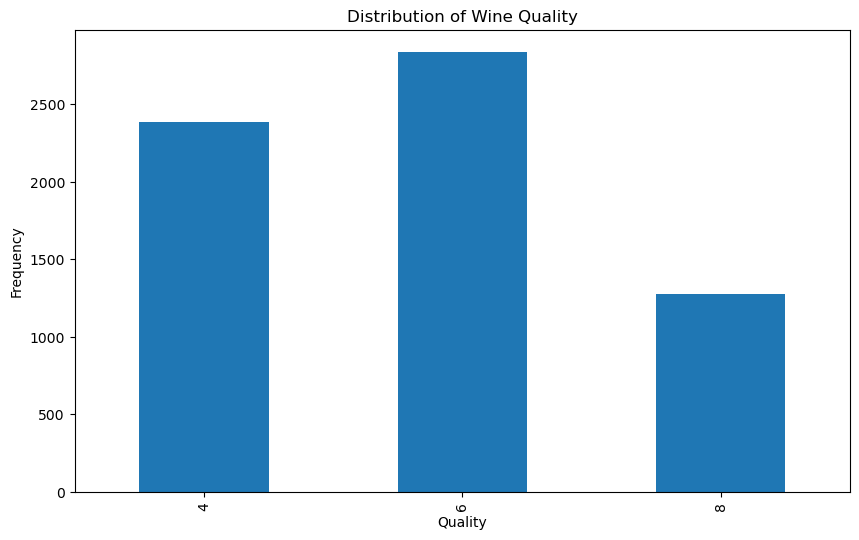

In [84]:
# Determine if data is balanced or imbalanced
plt.figure(figsize=(10, 6))
y.value_counts(sort=False).sort_index().plot(kind='bar')
plt.xlabel('Quality')
plt.ylabel('Frequency')
plt.title('Distribution of Wine Quality')
plt.show()

# Clustering or feature engineering by clumping 3s/4s/5s/ low  6s/ medium/ 7,8,9 high quality 

In [70]:
# # # Feature Selection: What features can we drop? 


Class distribution before resampling:
 quality
6    2269
4    1907
8    1021
Name: count, dtype: int64
Class distribution after resampling:
 quality
6    2269
8    2269
4    2269
Name: count, dtype: int64


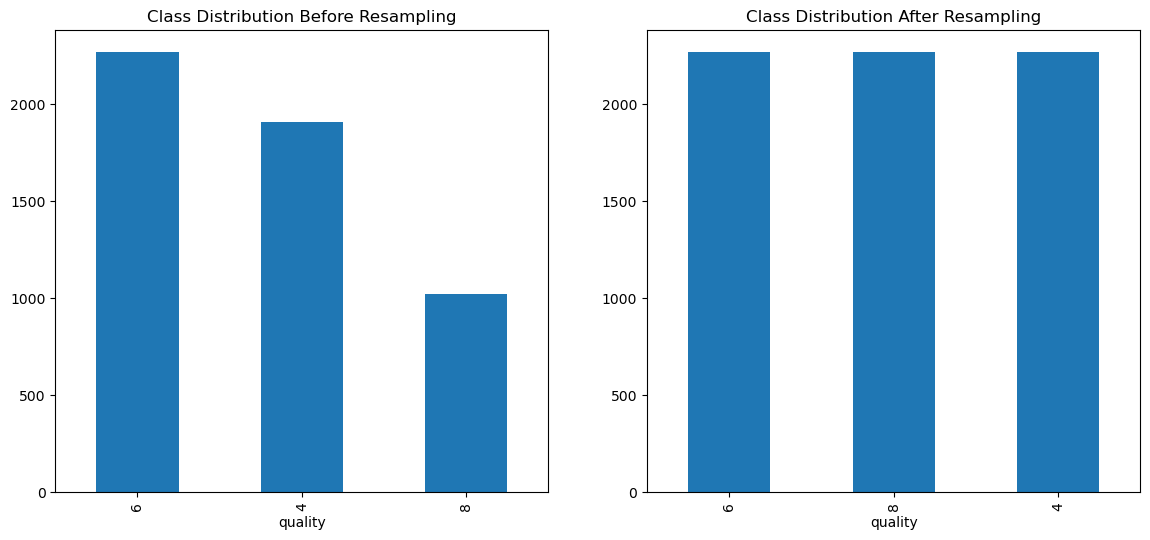

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    6807.000000       6807.000000  6807.000000     6807.000000   
mean        7.193020          0.332480     0.321679        5.376853   
std         1.266344          0.157569     0.137792        4.607650   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.400000          0.229341     0.260000        1.800000   
50%         6.961169          0.290000     0.310000        3.000000   
75%         7.600000          0.390000     0.390000        8.000000   
max        15.900000          1.330000     1.660000       31.600000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  6807.000000          6807.000000           6807.000000  6807.000000   
mean      0.054536            30.601912            114.936804     0.994466   
std       0.033668            17.629758             55.606414     0.002991   
min       0.009000             1.000000         

In [85]:
class_distribution_before = y_train.value_counts()
print("Class distribution before resampling:\n", class_distribution_before)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42, k_neighbors=3)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Class distribution after resampling
class_distribution_after = y_train_resampled.value_counts()
print("Class distribution after resampling:\n", class_distribution_after)

# Plot the class distributions before and after resampling
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
class_distribution_before.plot(kind='bar', ax=axes[0], title='Class Distribution Before Resampling')
class_distribution_after.plot(kind='bar', ax=axes[1], title='Class Distribution After Resampling')
plt.show()
# Since our data is imbalanced, we may want to correct it by oversampling the minority classes 
print(X_train_resampled.describe())


### Scaling the Data


In [86]:

scaler = StandardScaler()

# Fit the scaler on the training data and transform the training data
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)

# Transform the testing data (use the same scaler fitted on the training data)
X_test_scaled = scaler.transform(X_test)

### Build Models

In [80]:
# Define a simpler parameter grid for RandomizedSearchCV
param_distributions = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.05],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'subsample': [0.8, 1.0]
}

# Initialize the Gradient Boosting Classifier
gb = GradientBoostingClassifier(random_state=42)

# Initialize the RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=gb,
    param_distributions=param_distributions,
    n_iter=20,  # Reduced number of iterations
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1 
)

# Perform the random search on the resampled and scaled training data
random_search.fit(X_train_resampled, y_train_resampled)

# Get the best model
best_gb = random_search.best_estimator_

# Predict on the scaled test data
y_pred_gb = best_gb.predict(X_test)

# Evaluate the best model
print("Best Gradient Boosting Classifier Classification Report:")
print(classification_report(y_test, y_pred_gb))
print("Best Gradient Boosting Classifier Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_gb))

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=  10.8s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=  11.4s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=  11.9s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=  16.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=  17.0s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=200, subsample=1.0; total time=  23.5s
[CV] END learning_rat

/opt/anaconda3/envs/ai_dev/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/ai_dev/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/ai_dev/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [87]:
print(best_gb)
classifier = GradientBoostingClassifier(max_depth=5, max_features='log2',min_samples_split=5, n_estimators=500,random_state=42)
classifier.fit(X=X_train_resampled, y=y_train_resampled)
y_pred_best = classifier.predict(X_test)

print("Best Gradient Boosting Classifier Classification Report:")
print(classification_report(y_test, y_pred_best))
print("Best Gradient Boosting Classifier Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best))

GradientBoostingClassifier(max_depth=5, max_features='log2',
                           min_samples_split=5, n_estimators=200,
                           random_state=42)
Best Gradient Boosting Classifier Classification Report:
              precision    recall  f1-score   support

           4       1.00      1.00      1.00       477
           6       1.00      1.00      1.00       567
           8       1.00      1.00      1.00       256

    accuracy                           1.00      1300
   macro avg       1.00      1.00      1.00      1300
weighted avg       1.00      1.00      1.00      1300

Best Gradient Boosting Classifier Confusion Matrix:
[[477   0   0]
 [  0 567   0]
 [  0   0 256]]


With Scaling - RMSE: 1.0133891612838817, R^2: -0.4367073899417533


### Evaluation & Interpretation 

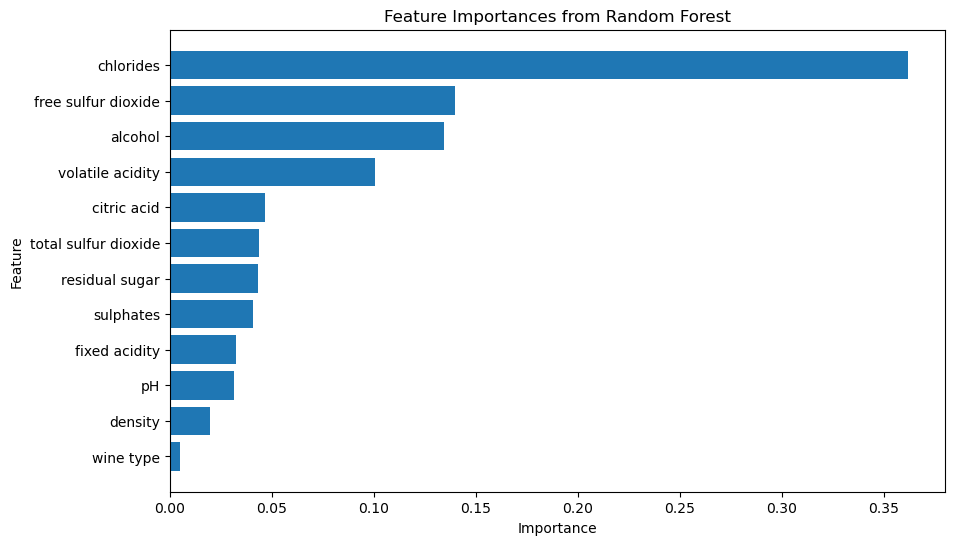